In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re
import matplotlib as mpl

plt.rcParams["font.family"] = "Malgun Gothic"  
mpl.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("2025_Airbnb_NYC_listings.csv")
df

,Unnamed: 0,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009-12-11,"New York, NY",...,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010-07-04,"New York, NY",...,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010-07-13,"New York, NY",...,4.88,4.86,4.62,OSE-STRREG-0001784,f,1,0,1,0,0.28
3,3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010-07-14,"New York, NY",...,4.96,4.79,4.82,OSE-STRREG-0000476,f,1,1,0,0,1.36
4,4,39282,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010-07-16,"New York, NY",...,4.88,4.85,4.78,OSE-STRREG-0001150,f,2,0,2,0,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,37429,1366333532374850165,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015-07-30,"New York, NY",...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
22304,37430,1366717321390111215,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022-10-10,"New York, NY",...,NaN,NaN,NaN,NaN,f,24,0,24,0,NaN
22305,37431,1366721904709517353,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015-03-30,"Hawthorne, NJ",...,NaN,NaN,NaN,NaN,f,48,48,0,0,NaN
22306,37432,1366722692755341871,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021-06-15,"New York, NY",...,NaN,NaN,NaN,NaN,t,25,25,0,0,NaN


In [28]:
# 전처리 1 - id int로 변경
df['id'] = df['id'].astype(int)

# booking_info
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['instant_bookable'] =  df['instant_bookable'].map({'f':0, 't':1})
df['is_long_term'] = (df['minimum_nights'] >= 28).astype(int)

# amenities_info
def parse_amenities(x):
    try:
        return [a.strip().strip('"').strip("'") for a in ast.literal_eval(x)]
    except:
        return []
    
df['amenities'] = df['amenities'].apply(parse_amenities)
df['amenities_cnt'] = df['amenities'].apply(len)

# host_info
# neighborhood_overview 결측치 많아서 유무대체 
df['neighborhood_overview_exists'] = df['neighborhood_overview'].notnull().astype(int)

# name 글자수기준 중앙값으로 그룹
df['name_length'] = df['name'].fillna('').astype(str).apply(len)
med_length = df['name_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
    
df['name_length_group'] = df['name_length'].apply(lambda x: name_length_group(x, med_length))

# description 글자수기준(결측치 405) 평균으로 그룹
df['description_length'] = df['description'].fillna('').astype(str).apply(len)
avg_length = df['description_length'].mean()

def name_length_group(length, avg):
    if length == 0:
        return 'empty'
    elif length > avg:
        return 'long'
    else:
        return 'short_or_avg'
    
df['description_length_group'] = df['description_length'].apply(lambda x: name_length_group(x, avg_length))

# host_about (결측치8917) 평균(243) 중앙값(81) 중앙값기준으로 그룹
df['host_about_length'] = df['host_about'].fillna('').astype(str).apply(len)
med_length = df['host_about_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
df['host_about_length_group'] = df['host_about_length'].apply(lambda x: name_length_group(x, med_length))


#host_identity_verified/host_has_profile_pic /host_is_superhost  
# True / Flase 1과 0으로 대체 (결측치 20/20/350 0으로 대체함)
df['host_identity_verified']=df['host_identity_verified'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_has_profile_pic']=df['host_has_profile_pic'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_is_superhost']=df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

# host_response_time 결측치는 중앙값으로 치환후 점수
response_time_score_map = { 
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_score'] = df['host_response_time'].map(response_time_score_map)

# 2. response_time_score 컬럼의 중앙값 계산
med_score_for_fillna = df['host_response_time_score'].median()

# 3. response_time_score 컬럼의 NaN을 계산된 중앙값으로 대체 
df['host_response_time_score'] = df['host_response_time_score'].fillna(med_score_for_fillna)

# host_response_time 칼럼에는 여전히 nan값 존재함
# response_time_score 칼럼만 중앙값대체 


# host_response_rate 컬럼 %제외하고 중앙값으로 대체
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate2 = df['host_response_rate'].median()
df['host_response_rate']= df['host_response_rate'].fillna(med_rate2)

# 4그룹으로 나눠 점수
conditions = [
    (df['host_response_rate'] <= 0.25),
    (df['host_response_rate'] > 0.25) & (df['host_response_rate'] <= 0.5),
    (df['host_response_rate'] > 0.5) & (df['host_response_rate'] <= 0.75),
    (df['host_response_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_response_rate_score'] = np.select(conditions, choices)


# host_acceptance_rate 칼럼도 %제외하고 중앙값으로 대체 
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate = df['host_acceptance_rate'].median()
df['host_acceptance_rate']= df['host_acceptance_rate'].fillna(med_rate)

conditions = [
    (df['host_acceptance_rate'] <= 0.25),
    (df['host_acceptance_rate'] > 0.25) & (df['host_acceptance_rate'] <= 0.5),
    (df['host_acceptance_rate'] > 0.5) & (df['host_acceptance_rate'] <= 0.75),
    (df['host_acceptance_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_acceptance_rate_score'] = np.select(conditions, choices)

# host_location 칼럼 
# host_loc 존재?
df['host_location_boolean'] = df['host_location'].notnull().astype(int)
# host_loc in NY?
df['host_location_ny'] = df['host_location'].str.contains('New York', na=False).astype(int)



#rooms_info
# --- Personal preprocessing code ---
# Convert "beds" from float to int
# Replace missing or non-bed values with median (assumed 1)
df['beds'] = df['beds'].fillna(0).astype(int)
df['beds'] = df['beds'].replace(0, 1)

# Clean up "bathrooms", "bathrooms_text" column:
# - Replace invalid or missing values with median (assumed 1)
df['bathrooms'] = df['bathrooms'].fillna(0)

def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    if 'half' in s:
        return 0.5
    return np.nan

df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)
mask_mismatch = df['bathrooms_parsed'].notna() & (df['bathrooms'] != df['bathrooms_parsed'])
df.loc[mask_mismatch, 'bathrooms'] = df.loc[mask_mismatch, 'bathrooms_parsed']
df = df.drop(columns=['bathrooms_parsed'])

df['bathrooms_text'] = df['bathrooms_text'].fillna(0)

df['is_shared'] = df['bathrooms_text'] \
    .str.contains('shared', case=False, na=False)

df['is_private'] = ~df['is_shared']

w_private = 1.0   # 전용 욕실 가중치
w_shared  = 0.5   # 공용 욕실 가중치

df['bath_score_mul'] = (
    df['bathrooms'] * np.where(df['is_private'], w_private, w_shared)
)

df['bathrooms'] = df['bathrooms'].replace(0.00, 1)
df['bath_score_mul'] = df['bath_score_mul'].replace(0.00, 1)

# Clean up "room_type", "property_type" column:
#
def extract_structure(pt):
    pt_l = pt.strip().lower()
    if ' in ' in pt_l:
        return pt_l.split(' in ',1)[1].strip()
    if pt_l.startswith('entire '):
        return pt_l.replace('entire ','').strip()
    if pt_l.startswith('private room'):
        return pt_l.replace('private room','').strip()
    if pt_l.startswith('shared room'):
        return pt_l.replace('shared room','').strip()
    return pt_l

rt_cats = set(df['room_type'].str.strip().str.lower())
df['structure_type'] = df['property_type'].apply(lambda x: (
    x.strip().lower() if x.strip().lower() not in rt_cats
    else pd.NA
))

mask = df['structure_type'].notna()
df.loc[mask, 'structure_type'] = df.loc[mask, 'structure_type'].apply(extract_structure)

residential = {
    'rental unit','home','condo','townhouse','cottage',
    'bungalow','villa','vacation home','earthen home',
    'ranch','casa particular','tiny home','entire home/apt'
}
apartment_suite = {
    'guest suite','loft','serviced apartment','aparthotel',
    'private room'
}
hotel_lodging = {
    'hotel','boutique hotel','bed and breakfast',
    'resort','hostel','guesthouse','hotel room'
}

def map_category(row):
    pt = row['property_type'].strip().lower()
    rt = row['room_type'].strip().lower()
    st = row['structure_type']
    if rt in residential or pt in residential or (isinstance(st, str) and st in residential):
        return 'Residential'
    elif rt in apartment_suite or pt in apartment_suite or (isinstance(st, str) and st in apartment_suite):
        return 'Apartment_Suite'
    elif rt in hotel_lodging or pt in hotel_lodging or (isinstance(st, str) and st in hotel_lodging):
        return 'Hotel_Lodging'
    else:
        return 'Others'

df['structure_category'] = df.apply(map_category, axis=1)


for col in [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].round(2)



<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
C:\Users\HY\AppData\Local\Temp\ipykernel_12620\1019980279.py:5: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\HY\AppData\Local\Temp\ipykernel_12620\1019980279.py:236: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [29]:
'''
# host_since 년도로 바꾸기, 결측치 비율 0.09%-> 0으로 
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_since'] = df['host_since'].dt.year
df['host_since'] = df['host_since'].fillna(0).astype(int)
df['host_since'] = df['host_since'].astype(int)

# last_review 년도로 바꾸기, 결측치 비율 30% -> 0으로
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review'] = df['last_review'].dt.year
df['last_review'] = df['last_review'].fillna(0).astype(int)
df['last_review'] = df['last_review'].astype(int)

# 비활성화 조건
cond1 = (df['last_review'] <= 2022) & (df['last_review'] != 0) & (df['estimated_occupancy_l365d'] == 0)
cond2 = (df['host_since'] <= 2022) & (df['number_of_reviews'] == 0) & (df['estimated_occupancy_l365d'] == 0)

# 활성화=1 비활성화=0
df['is_activate'] = np.select([cond1, cond2], [0, 0], default=1)
'''


"\n# host_since 년도로 바꾸기, 결측치 비율 0.09%-> 0으로 \ndf['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')\ndf['host_since'] = df['host_since'].dt.year\ndf['host_since'] = df['host_since'].fillna(0).astype(int)\ndf['host_since'] = df['host_since'].astype(int)\n\n# last_review 년도로 바꾸기, 결측치 비율 30% -> 0으로\ndf['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')\ndf['last_review'] = df['last_review'].dt.year\ndf['last_review'] = df['last_review'].fillna(0).astype(int)\ndf['last_review'] = df['last_review'].astype(int)\n\n# 비활성화 조건\ncond1 = (df['last_review'] <= 2022) & (df['last_review'] != 0) & (df['estimated_occupancy_l365d'] == 0)\ncond2 = (df['host_since'] <= 2022) & (df['number_of_reviews'] == 0) & (df['estimated_occupancy_l365d'] == 0)\n\n# 활성화=1 비활성화=0\ndf['is_activate'] = np.select([cond1, cond2], [0, 0], default=1)\n"

In [30]:
df

,Unnamed: 0,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,...,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,structure_type,structure_category
0,0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009-12-11,"New York, NY",...,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
1,1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010-07-04,"New York, NY",...,4.0,4,4,1,1,False,True,1.0,condo,Residential
2,2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010-07-13,"New York, NY",...,3.0,4,2,1,1,False,True,2.5,home,Residential
3,3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010-07-14,"New York, NY",...,4.0,4,4,1,1,False,True,1.0,home,Residential
4,4,39282,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010-07-16,"New York, NY",...,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,37429,1366333532374850165,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015-07-30,"New York, NY",...,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
22304,37430,1366717321390111215,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022-10-10,"New York, NY",...,4.0,4,4,1,1,False,True,1.0,rental unit,Residential
22305,37431,1366721904709517353,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015-03-30,"Hawthorne, NJ",...,4.0,4,4,1,0,False,True,2.0,rental unit,Residential
22306,37432,1366722692755341871,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021-06-15,"New York, NY",...,4.0,4,4,1,1,False,True,1.0,rental unit,Residential


availability_30/60/90/365 

예약가능여부가 예약으로 인한 불가인지 호스트가 의도적으로 막아둔 것으로 인한 불가인지 모호

네칼럼 비교했을때 30/60/90 데이터가 0인데 365만 값이 있는 경우가 많다
그래서 장기임대용 숙소여서 3개월이내로는 단기라고 보고 받지않나 했지만 maximum_nights/minimum_nights 확인했을때 아님
3개월이내 날짜는 모두 예약이 불가능하지만 장기적으로 봤을때 이후에는 예약이 가능하다?

In [31]:
# 조건에 맞는 숙소 필터링
subset = df[
    (df['availability_30'] == 0) &
    (df['availability_60'] == 0) &
    (df['availability_90'] == 0) &
    (df['availability_365'] > 0)
].copy()

# 개수 확인
print(f"조건에 맞는 숙소 수: {len(subset)}")

# 주요 칼럼들 출력 (상위 10개)
display(subset[['availability_30', 'availability_60', 'availability_90', 'availability_365', 
              'minimum_nights', 'maximum_nights', 'last_review', 'host_since']].head(10))


조건에 맞는 숙소 수: 2253


,availability_30,availability_60,availability_90,availability_365,minimum_nights,maximum_nights,last_review,host_since
1,0,0,0,204,30,999,2023-12-09,2010-07-04
15,0,0,0,176,30,60,2015-12-08,2011-04-19
17,0,0,0,89,30,90,2024-12-01,2011-04-21
18,0,0,0,145,30,240,2024-08-31,2010-07-29
25,0,0,0,110,30,365,2025-01-06,2009-10-31
33,0,0,0,60,30,31,2023-09-04,2010-09-01
44,0,0,0,57,30,365,2023-09-05,2009-12-26
67,0,0,0,61,30,365,2022-05-31,2009-09-29
73,0,0,0,213,30,180,2023-12-02,2011-05-24
81,0,0,0,92,30,1125,2025-01-07,2010-11-03


In [32]:
df['availability_365'].value_counts()
#365인 숙소: 2783 -> 예약없는 신규숙소이거나 수요가 매우 낮은 숙소일 가능성 
#0인 숙소 : 168 -> 지속적으로 예약이 되어있거나(단기숙박이 아닌 장기숙박일가능성높다),호스트가 의도적으로 막아둠 

availability_365
365    2783
364    1136
363     713
269     540
180     445
       ... 
4         9
12        8
14        7
7         6
22        6
Name: count, Length: 366, dtype: int64

시간경과에 따라서?
availability_365 에서 availability_30/60/90데이터를 뺐을때 단기적으로 얼마나 예약이 불가능해졌나-> 차이가 크면 예약이 가능한 날은 많았지만 30/60/90일 기준으로

335 (6057개 숙소): 표준적인 케이스/ 365일 열려있고 30일이내가능일도 30일인 경우
신규숙소이거나 낮은 수요/ 가격이 높거나 다른 이유로 경쟁력이 낮을 가능성

240 (1250개 숙소): 

335    6057
240    1250
60     1246
150    1181
0       370
       ... 
9         8
13        8
166       6
20        6
7         5
Name: count, Length: 336, dtype: int64


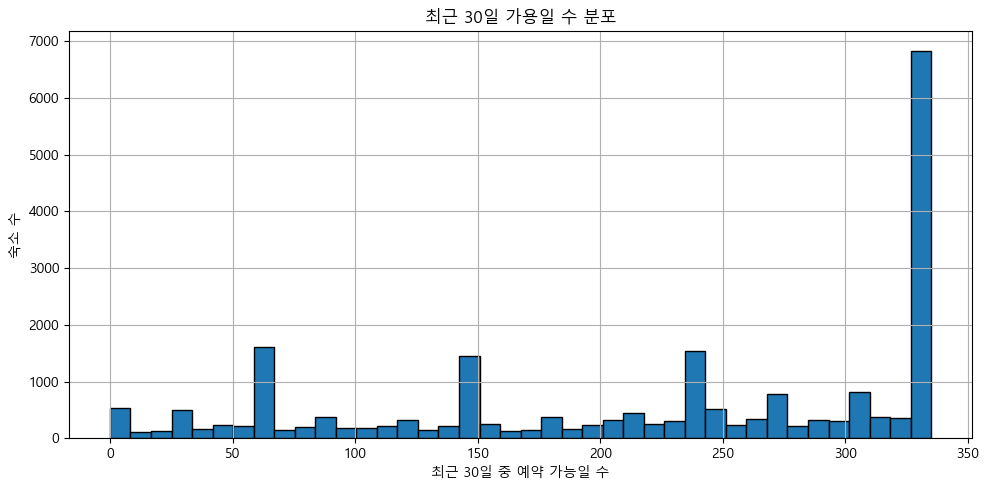

In [33]:
availability = df['availability_365'] - df['availability_30']
print(availability.value_counts().sort_values(ascending=False))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
availability.plot(kind='hist', bins=40, edgecolor='black')
plt.title('최근 30일 가용일 수 분포')
plt.xlabel('최근 30일 중 예약 가능일 수')
plt.ylabel('숙소 수')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
availability_60 = df['availability_365'] - df['availability_60']
availability_90 = df['availability_365'] - df['availability_90']
print(availability_60.value_counts())
print(availability_90.value_counts())

305    7045
210    1387
120    1336
30     1328
0       855
       ... 
12        9
48        9
37        8
39        6
4         5
Name: count, Length: 306, dtype: int64
275    7937
0      2525
90     1520
180    1512
274     349
       ... 
48        4
10        4
12        4
9         3
39        3
Name: count, Length: 276, dtype: int64


availability_365 와 number_of_reviews_l365d
1년 중 오픈일수가 적지만 리뷰수가 많다면 인기있는 숙소(인기가 많아서 예약할수없는 숙소아닐까?)

In [35]:
popular = df['number_of_reviews_ltm']/df['availability_365']
print(popular.value_counts().sort_values(ascending=False))

0.000000    12117
0.002740      264
0.005479      121
0.002747      116
0.011111       85
            ...  
0.113744        1
0.328125        1
0.065282        1
0.026087        1
1.680000        1
Name: count, Length: 3526, dtype: int64


In [36]:
# 리뷰가 0개이거나 365가 0일 가능성-> 리뷰는 0인데 365는 0이 아님 운영중이고 예약가능하지만 리뷰가 없음
zero_popular = df[popular == 0][['number_of_reviews_ltm', 'availability_365']]
print(zero_popular.head(10))
print(f"총 개수: {len(zero_popular)}")

# 0보다 크면 100일 오픈하면 1개 달릴까 말까? ->리뷰수가 availability 대비 매우 낮다
target_value = 0.01
tolerance = 0.001
near_target = df[(popular >= target_value - tolerance) & (popular <= target_value + tolerance)][['number_of_reviews_ltm', 'availability_365']]
print(near_target.head(10))
print(f"총 개수: {len(near_target)}")

# 1보다도 큰값은 availability가 적은데 리뷰가 많다.-> 8일 예약가능인데 리뷰가 17개/ 13일 예약가능 리뷰39개 (파티룸이나 단기로 빌리는 곳?)
high_popular = df[popular >= 1][['number_of_reviews_ltm', 'availability_365']]
print(high_popular.head(10))
print(f"총 개수: {len(high_popular)}")

    number_of_reviews_ltm  availability_365
0                       0               362
1                       0               204
2                       0               326
5                       0               365
7                       0                83
11                      0               150
12                      0               144
14                      0               365
15                      0               176
16                      0               173
총 개수: 12117
     number_of_reviews_ltm  availability_365
42                       3               280
144                      1                93
153                      3               301
176                      3               274
210                      2               193
237                      2               213
284                      3               316
397                      2               183
398                      2               219
420                      3               332
총 개수: 488

In [37]:
df.loc[popular.sort_values(ascending=False).index[:10], ['number_of_reviews_ltm', 'availability_365']]

,number_of_reviews_ltm,availability_365
10548,3,0
12942,20,0
7233,1,0
11262,38,0
417,9,0
6457,1,0
3419,34,0
9055,122,0
6772,1,0
4841,4,0


availability_365
0일경우 예약가능한 날이 없다-> 이미 모든일정 예약 완료, 호스트의 차단(운영중단)
365일 경우 항상예약이 가능하다-> 신규숙소, 수요가 낮음, 장기임대로만 가능한 숙소 

availability_365-예약가능일수 estimated_occupancy_l365d-예약된일수 추정치?
availability_365 = 0, estimated_occupancy_l365d > 0 일경우 
예약가능한 날짜는 없는데 이전에 예약이 많았던 숙소 
- 예약이 다 차서 가능한 날짜가 없을 가능성
availability_365 > 0, estimated_occupancy_l365d = 0 일경우 
예약 가능한 날짜는 있으나, 지난 1년 동안 실제 예약은 하나도 안 됨
- 비인기 숙소이거나 신규호스트의 숙소 


In [38]:
# 비교 대상
cond_1 = (df['availability_365'] == 0) & (df['estimated_occupancy_l365d'] > 0)
cond_2 = (df['availability_365'] > 0) & (df['estimated_occupancy_l365d'] == 0)

print("예약은 있었지만 현재 예약 가능일이 없는 숙소 (availability_365=0, occupancy>0):")
print(df[cond_1][['availability_365', 'estimated_occupancy_l365d']].head())
print(f"총 개수: {cond_1.sum()}개")

print("\n예약 가능하지만 지난 1년 예약이 없었던 숙소 (availability>0, occupancy=0):")
print(df[cond_2][['availability_365', 'estimated_occupancy_l365d']].head())
print(f"총 개수: {cond_2.sum()}개")

예약은 있었지만 현재 예약 가능일이 없는 숙소 (availability_365=0, occupancy>0):
      availability_365  estimated_occupancy_l365d
10                   0                         60
417                  0                        115
682                  0                         60
1471                 0                        180
2927                 0                        255
총 개수: 51개

예약 가능하지만 지난 1년 예약이 없었던 숙소 (availability>0, occupancy=0):
   availability_365  estimated_occupancy_l365d
0               362                          0
1               204                          0
2               326                          0
5               365                          0
7                83                          0
총 개수: 12117개


In [40]:
from datetime import datetime

df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# 오늘 날짜 기준
today = pd.to_datetime("today")

# 3. 신규 호스트로 아직 예약 없음
new_no_booking = df[
    (df['host_since'] >= pd.to_datetime("2024-07-01")) &  # 최근 1년 내 가입
    (df['estimated_occupancy_l365d'] == 0)
]
print("최근 생성된 신규 숙소 중 예약 없는 경우:")
print(new_no_booking[['host_since', 'availability_365', 'estimated_occupancy_l365d']])


최근 생성된 신규 숙소 중 예약 없는 경우:
      host_since  availability_365  estimated_occupancy_l365d
19137 2024-12-01               213                          0
20117 2024-10-04               362                          0
20174 2024-10-01               364                          0
20191 2024-10-15                87                          0
20225 2024-10-22               364                          0
...          ...               ...                        ...
22232 2024-12-05               364                          0
22233 2024-12-05               364                          0
22234 2024-12-05               364                          0
22235 2024-12-05               364                          0
22240 2024-10-10                36                          0

[196 rows x 3 columns]
